In [72]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os
import torch.cuda
import albumentations as albu
import segmentation_models_pytorch as smp
from  segmentation_models_pytorch.utils.base import Metric
from segmentation_models_pytorch.base.modules import Activation
from collections import defaultdict

In [73]:
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [74]:
DATASET_2D_BASE_PATH=Path('G:\ML Project Datasets\Medical Image\MM-WH 2017 Dataset\Axials Version')
WIDTH=320
HEIGHT=320

In [75]:
def load_data(path):
    
    all_images=os.listdir(path/'images')
    all_masks=os.listdir(path/'masks')
    
    data = {'images':[],
           'masks':[]}
    for i in range(len(all_images)):
        data['images'].append(str(path/'images'/all_images[i]))
        data['masks'].append(str(path/'masks'/all_masks[i]))
    return pd.DataFrame(data)
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
        

In [76]:
df_train=load_data(DATASET_2D_BASE_PATH/'train')[0:24]
df_val=load_data(DATASET_2D_BASE_PATH/'val')[0:8]
df_train

,images,masks
0,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
1,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
2,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
3,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
4,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
5,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
6,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
7,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
8,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...
9,G:\ML Project Datasets\Medical Image\MM-WH 201...,G:\ML Project Datasets\Medical Image\MM-WH 201...


In [77]:

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_path, 
            masks_path, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.images = images_path
        self.masks = masks_path
        
    def __getitem__(self, i):
#         print(self.images[i])
        image = cv2.imread(str(self.images[i]))
        mask = cv2.imread(self.masks[i],0)
        mask=np.expand_dims(mask,axis=-1)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
    def __len__(self):
        return len(self.images)

In [78]:
def get_training_augmentation():
    train_transform = [

   
        albu.Resize(HEIGHT,WIDTH),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.2,p=1, border_mode=cv2.BORDER_CONSTANT),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Blur(blur_limit=3, p=0.4),
        albu.GaussNoise(p=0.5),
        albu.RandomBrightnessContrast(brightness_limit=0.3,contrast_limit=0.3,p=0.5),
        albu.RandomBrightness(p=0.75)

    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
  
    test_transform = [
        albu.Resize(HEIGHT,WIDTH)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):  
    return x.transpose(2, 0, 1).astype('float32')



def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [79]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
TRAIN_RUNS_PATH=r'G:\Projects and Work\Mouse Heart Segmentation\runs'
MODEL_NAME='Unet'
BATCH_SIZE=8
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [80]:
WEIGHTS_PATH=os.path.join(TRAIN_RUNS_PATH,f'{MODEL_NAME}_{ENCODER}')
WEIGHTS_PATH

'G:\\Projects and Work\\Mouse Heart Segmentation\\runs\\Unet_se_resnext50_32x4d'

In [81]:
summary(model, input_size=(3,320,320), batch_size=BATCH_SIZE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 160, 160]           9,408
       BatchNorm2d-2          [8, 64, 160, 160]             128
              ReLU-3          [8, 64, 160, 160]               0
         MaxPool2d-4            [8, 64, 80, 80]               0
            Conv2d-5           [8, 128, 80, 80]           8,192
       BatchNorm2d-6           [8, 128, 80, 80]             256
              ReLU-7           [8, 128, 80, 80]               0
            Conv2d-8           [8, 128, 80, 80]           4,608
       BatchNorm2d-9           [8, 128, 80, 80]             256
             ReLU-10           [8, 128, 80, 80]               0
           Conv2d-11           [8, 256, 80, 80]          32,768
      BatchNorm2d-12           [8, 256, 80, 80]             512
           Conv2d-13           [8, 256, 80, 80]          16,384
      BatchNorm2d-14           [8, 256,

In [82]:
class DCS(Metric):
    __name__ = 'DCS'

    def __init__(self, eps=0.00001, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
     
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        dice_numerator = 2 * torch.sum(y_pr * y_gt) + self.eps
        dice_denominator = torch.sum(y_pr) + torch.sum(y_gt) + self.eps
        dice_coefficient = dice_numerator / dice_denominator
        return dice_coefficient


In [83]:
train_dataset = Dataset(
    df_train['images'], 
    df_train['masks'], 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    df_val['images'], 
    df_val['masks'], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
) 




g:\projects and work\mouse heart segmentation\venv\lib\site-packages\albumentations\augmentations\transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [84]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    DCS()
    
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [85]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [86]:
# train model for 100 epochs
EPOCHS=10
if os.path.exists(WEIGHTS_PATH)==False:
    os.mkdir(WEIGHTS_PATH)
else:
    print(f"Warning! Directory {WEIGHTS_PATH } already exists")

Warning! Directory G:\Projects and Work\Mouse Heart Segmentation\runs\Unet_se_resnext50_32x4d already exists


In [87]:
min_loss = 100000000
train_history=defaultdict(list)
valid_history=defaultdict(list)

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if min_loss > valid_logs['dice_loss']:
        min_loss = valid_logs['dice_loss']
        torch.save(model, os.path.join(WEIGHTS_PATH,f'best_{str(i)}_{round(min_loss,4)}.pt'))
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
    # Maintain History
    for log_key in train_logs.keys():
        train_history[log_key].append(train_logs[log_key])
        valid_history[log_key].append(valid_logs[log_key])


Epoch: 0
valid: 100%|██████████████████| 8/8 [00:00<00:00, 29.60it/s, dice_loss - 0.9984, iou_score - 0.0008097, DCS - 0.001535]
Model saved!

Epoch: 1
valid: 100%|██████████████████| 8/8 [00:00<00:00, 29.02it/s, dice_loss - 0.9985, iou_score - 0.0008891, DCS - 0.001509]

Epoch: 2
valid: 100%|██████████████████| 8/8 [00:00<00:00, 29.41it/s, dice_loss - 0.9985, iou_score - 0.0009557, DCS - 0.001523]

Epoch: 3
valid: 100%|███████████████████| 8/8 [00:00<00:00, 28.77it/s, dice_loss - 0.9984, iou_score - 0.001024, DCS - 0.001558]
Model saved!

Epoch: 4
valid: 100%|███████████████████| 8/8 [00:00<00:00, 29.62it/s, dice_loss - 0.9984, iou_score - 0.001156, DCS - 0.001623]
Model saved!

Epoch: 5
valid: 100%|███████████████████| 8/8 [00:00<00:00, 29.41it/s, dice_loss - 0.9983, iou_score - 0.001247, DCS - 0.001679]
Model saved!

Epoch: 6
valid: 100%|███████████████████| 8/8 [00:00<00:00, 28.87it/s, dice_loss - 0.9983, iou_score - 0.001251, DCS - 0.001679]
Model saved!

Epoch: 7
valid: 100%|███

Text(0, 0.5, 'dice_loss')

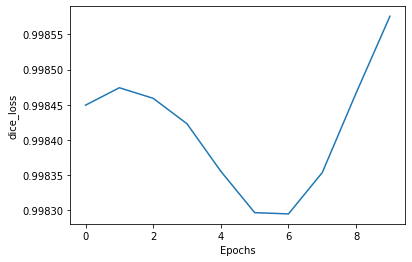

In [92]:
plt.plot(valid_history['dice_loss'])
plt.xlabel("Epochs")
plt.ylabel("dice_loss")

In [94]:
pd.DataFrame(valid_history).to_csv(os.path.join(WEIGHTS_PATH,'validation_logs.csv'))
pd.DataFrame(train_history).to_csv(os.path.join(WEIGHTS_PATH,'train_logs.csv'))